In [376]:
import os
import warnings
from datetime import datetime
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.exceptions import ConvergenceWarning

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

In [377]:
sns.set()
pd.set_option('display.max_columns', None)

# 1. The HR Analytics Dataset

This dataset came from Kaggle:
https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset

Load the dataset from a csv file.

In [378]:
# Load the csv dataset into pandas dataframes
data_file = os.path.join(os.getcwd(), 'dataset', 'hr_employee_attrition.csv')
hr_df = pd.read_csv(data_file)
hr_df.head(3)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0


In [379]:
hr_df.describe(include='all')

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470,1470,1470.000000,1470,1470.000000,1470.000000,1470,1470.0,1470.000000,1470.000000,1470,1470.000000,1470.000000,1470.000000,1470,1470.000000,1470,1470.000000,1470.000000,1470.000000,1470,1470,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
unique,NaN,2,3,NaN,3,NaN,NaN,6,NaN,NaN,NaN,2,NaN,NaN,NaN,9,NaN,3,NaN,NaN,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,No,Travel_Rarely,NaN,Research & Development,NaN,NaN,Life Sciences,NaN,NaN,NaN,Male,NaN,NaN,NaN,Sales Executive,NaN,Married,NaN,NaN,NaN,Y,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1233,1043,NaN,961,NaN,NaN,606,NaN,NaN,NaN,882,NaN,NaN,NaN,326,NaN,673,NaN,NaN,NaN,1470,1054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,36.923810,NaN,NaN,802.485714,NaN,9.192517,2.912925,NaN,1.0,1024.865306,2.721769,NaN,65.891156,2.729932,2.063946,NaN,2.728571,NaN,6502.931293,14313.103401,2.693197,NaN,NaN,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,NaN,NaN,403.509100,NaN,8.106864,1.024165,NaN,0.0,602.024335,1.093082,NaN,20.329428,0.711561,1.106940,NaN,1.102846,NaN,4707.956783,7117.786044,2.498009,NaN,NaN,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,NaN,NaN,102.000000,NaN,1.000000,1.000000,NaN,1.0,1.000000,1.000000,NaN,30.000000,1.000000,1.000000,NaN,1.000000,NaN,1009.000000,2094.000000,0.000000,NaN,NaN,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,NaN,NaN,465.000000,NaN,2.000000,2.000000,NaN,1.0,491.250000,2.000000,NaN,48.000000,2.000000,1.000000,NaN,2.000000,NaN,2911.000000,8047.000000,1.000000,NaN,NaN,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,NaN,NaN,802.000000,NaN,7.000000,3.000000,NaN,1.0,1020.500000,3.000000,NaN,66.000000,3.000000,2.000000,NaN,3.000000,NaN,4919.000000,14235.500000,2.000000,NaN,NaN,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,NaN,NaN,1157.000000,NaN,14.000000,4.000000,NaN,1.0,1555.750000,4.000000,NaN,83.750000,3.000000,3.000000,NaN,4.000000,NaN,8379.000000,20461.500000,4.000000,NaN,NaN,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000


All rows have values for each column. Therefore, there's no need to drop any rows.

In [380]:
hr_df.columns[hr_df.isna().any()].tolist()

[]

Upon inspection, column ```Over18``` has values that are all 'Y'. A good assumption would be that a person has to be 18 years old at the minimum to be employed. Initially, this can be considered uselss. However, I retained this for the following reasons:  
1. Country - There are some countries where the legal minimum working age is lower than 18 (e.g. 15 for Japan). This dataset did not indicate which countries the employees are from.
2. Live Production Data - This dataset is a snippet in its current form. However, if production data is always extracted, there will always be a possibility that the opposite value, 'N', would appear.
3. Interns - While not present in the dataset, interns can be below 18 years old. In addition, every employer keeps records of their interns as they're still considered employees.

In [381]:
hr_df['Over18'].value_counts()

Y    1470
Name: Over18, dtype: int64

Column ```EmployeeCount``` contains a single value as well. However, this column does not make sense at all so I removed this one.

In [382]:
hr_df['EmployeeCount'].value_counts()

1    1470
Name: EmployeeCount, dtype: int64

In [383]:
hr_df.drop(['EmployeeCount'], axis=1, inplace=True)

Column ```StandardHours``` contains only one value which is 80. There is a possibility that in the future, there will be a new value. However, at present, we cannot invent rows with say, 88, without considering other variables. There, this column needs to be dropped.

In [384]:
hr_df['StandardHours'].value_counts()

80    1470
Name: StandardHours, dtype: int64

In [385]:
hr_df.drop(['StandardHours'], axis=1, inplace=True)

# Exploring the Data

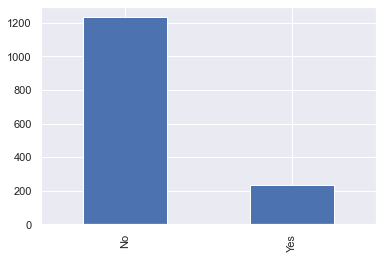

In [387]:
ax = hr_df['Attrition'].value_counts().plot(kind='bar');
# ax.set_xticklabel()

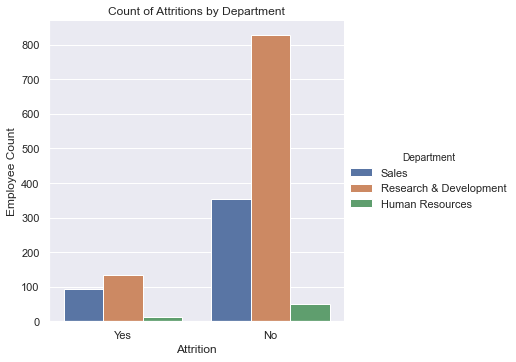

In [388]:
fig = sns.catplot(x='Attrition', kind='count', hue='Department' ,data=hr_df )
fig.set(xlabel='Attrition', ylabel="Employee Count", title="Count of Attritions by Department");

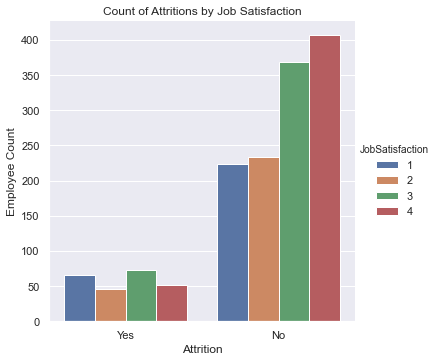

In [389]:
fig = sns.catplot(x='Attrition', kind='count', hue='JobSatisfaction' ,data=hr_df )
fig.set(xlabel='Attrition', ylabel="Employee Count", title="Count of Attritions by Job Satisfaction");

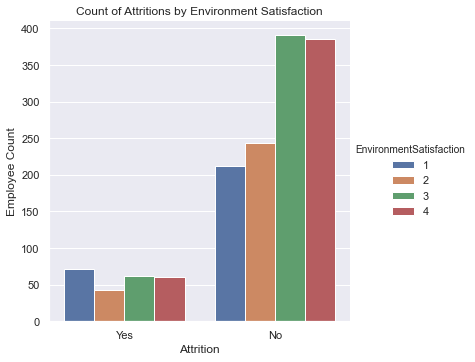

In [390]:
fig = sns.catplot(x='Attrition', kind='count', hue='EnvironmentSatisfaction' ,data=hr_df )
fig.set(xlabel='Attrition', ylabel="Employee Count", title="Count of Attritions by Environment Satisfaction");

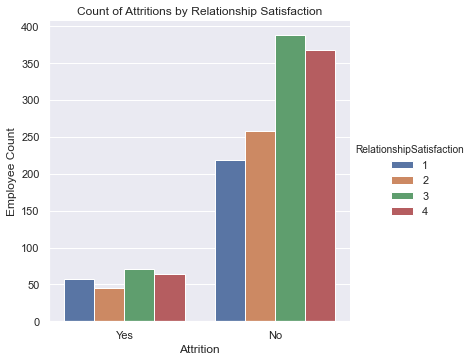

In [391]:
fig = sns.catplot(x='Attrition', kind='count', hue='RelationshipSatisfaction' ,data=hr_df )
fig.set(xlabel='Attrition', ylabel="Employee Count", title="Count of Attritions by Relationship Satisfaction");

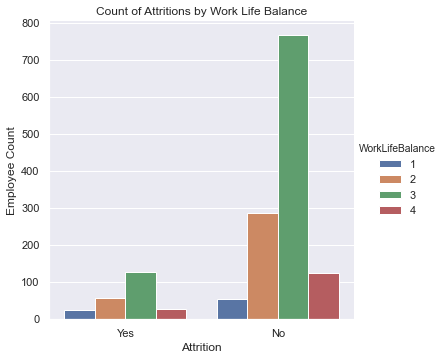

In [392]:
fig = sns.catplot(x='Attrition', kind='count', hue='WorkLifeBalance' ,data=hr_df )
fig.set(xlabel='Attrition', ylabel="Employee Count", title="Count of Attritions by Work Life Balance");

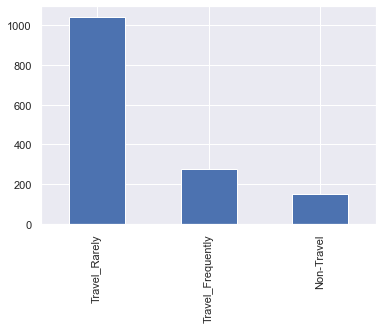

In [393]:
hr_df['BusinessTravel'].value_counts().plot(kind='bar')

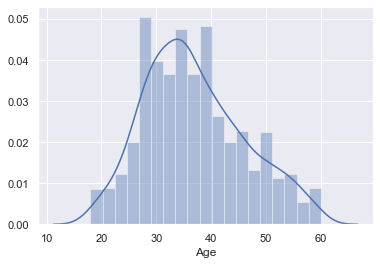

In [394]:
sns.distplot(hr_df['Age'])

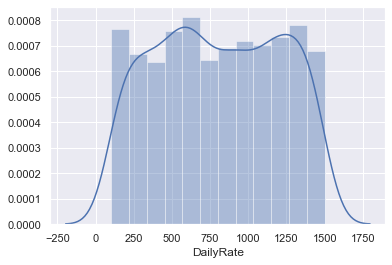

In [395]:
sns.distplot(hr_df['DailyRate'])

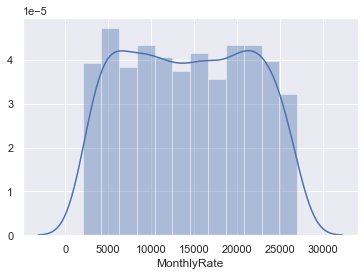

In [396]:
sns.distplot(hr_df['MonthlyRate'])

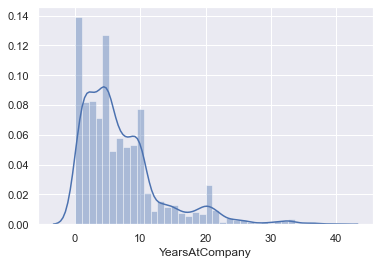

In [397]:
sns.distplot(hr_df['YearsAtCompany'])

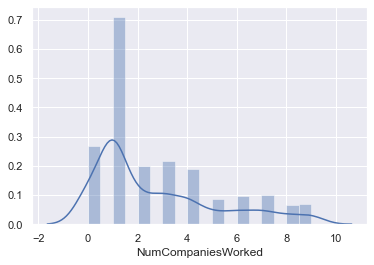

In [398]:
sns.distplot(hr_df['NumCompaniesWorked'])

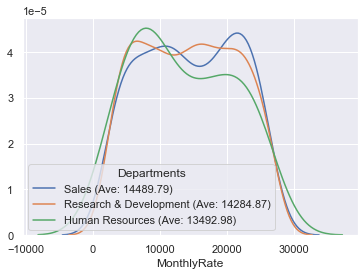

In [399]:
unique_depts = hr_df['Department'].unique()

for dept in unique_depts:
    subset = hr_df[hr_df['Department'] == dept]
    dept_mean = subset['MonthlyRate'].mean()
    dept_label = '{} (Ave: {:.2f})'.format(dept, dept_mean)
    sns.distplot(subset['MonthlyRate'], hist=False, label=dept_label)

plt.legend(title='Departments');

# EDA for those who were Attrited

In [400]:
leaver_df = hr_df[hr_df['Attrition'] == 'Yes']

In [401]:
leaver_df.head(2)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,0,8,0,1,6,4,0,5
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,0,7,3,3,0,0,0,0


In [402]:
leaver_df.describe(include='all')

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,237.000000,237,237,237.000000,237,237.000000,237.000000,237,237.000000,237.000000,237,237.000000,237.000000,237.000000,237,237.000000,237,237.000000,237.000000,237.000000,237,237,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000
unique,NaN,1,3,NaN,3,NaN,NaN,6,NaN,NaN,2,NaN,NaN,NaN,9,NaN,3,NaN,NaN,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Yes,Travel_Rarely,NaN,Research & Development,NaN,NaN,Life Sciences,NaN,NaN,Male,NaN,NaN,NaN,Laboratory Technician,NaN,Single,NaN,NaN,NaN,Y,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,237,156,NaN,133,NaN,NaN,89,NaN,NaN,150,NaN,NaN,NaN,62,NaN,120,NaN,NaN,NaN,237,127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,33.607595,NaN,NaN,750.362869,NaN,10.632911,2.839662,NaN,1010.345992,2.464135,NaN,65.573840,2.518987,1.637131,NaN,2.468354,NaN,4787.092827,14559.308017,2.940928,NaN,NaN,15.097046,3.156118,2.599156,0.527426,8.244726,2.624473,2.658228,5.130802,2.902954,1.945148,2.852321
std,9.689350,NaN,NaN,401.899519,NaN,8.452525,1.008244,NaN,580.750572,1.169791,NaN,20.099958,0.773405,0.940594,NaN,1.118058,NaN,3640.210367,7208.153264,2.678519,NaN,NaN,3.770294,0.363735,1.125437,0.856361,7.169204,1.254784,0.816453,5.949984,3.174827,3.153077,3.143349
min,18.000000,NaN,NaN,103.000000,NaN,1.000000,1.000000,NaN,1.000000,1.000000,NaN,31.000000,1.000000,1.000000,NaN,1.000000,NaN,1009.000000,2326.000000,0.000000,NaN,NaN,11.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,NaN,NaN,408.000000,NaN,3.000000,2.000000,NaN,514.000000,1.000000,NaN,50.000000,2.000000,1.000000,NaN,1.000000,NaN,2373.000000,8870.000000,1.000000,NaN,NaN,12.000000,3.000000,2.000000,0.000000,3.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,32.000000,NaN,NaN,699.000000,NaN,9.000000,3.000000,NaN,1017.000000,3.000000,NaN,66.000000,3.000000,1.000000,NaN,3.000000,NaN,3202.000000,14618.000000,1.000000,NaN,NaN,14.000000,3.000000,3.000000,0.000000,7.000000,2.000000,3.000000,3.000000,2.000000,1.000000,2.000000
75%,39.000000,NaN,NaN,1092.000000,NaN,17.000000,4.000000,NaN,1486.000000,4.000000,NaN,84.000000,3.000000,2.000000,NaN,3.000000,NaN,5916.000000,21081.000000,5.000000,NaN,NaN,17.000000,3.000000,4.000000,1.000000,10.000000,3.000000,3.000000,7.000000,4.000000,2.000000,5.000000


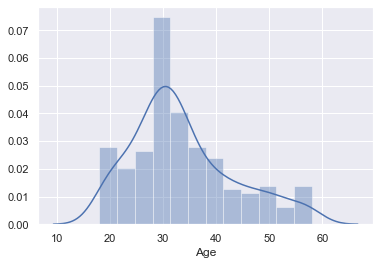

In [403]:
sns.distplot(leaver_df['Age'])

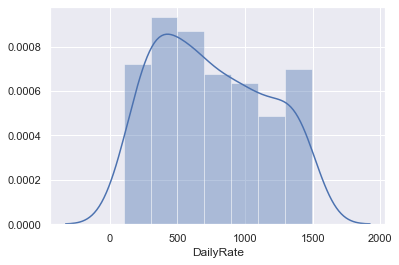

In [404]:
sns.distplot(leaver_df['DailyRate'])

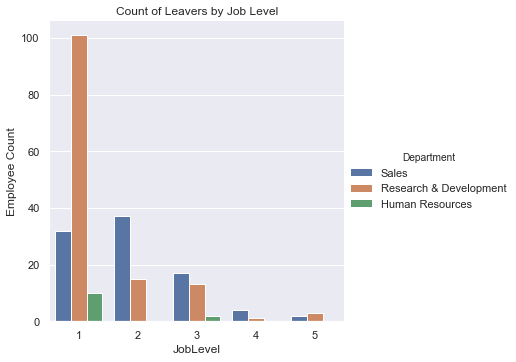

In [405]:
fig = sns.catplot(x='JobLevel', kind='count', hue='Department', data=leaver_df )
fig.set(xlabel='JobLevel', ylabel="Employee Count", title="Count of Leavers by Job Level");

In [406]:
leaver_df[leaver_df['Department'] == 'Research & Development']['JobRole'].value_counts()

Laboratory Technician        62
Research Scientist           47
Manufacturing Director       10
Healthcare Representative     9
Manager                       3
Research Director             2
Name: JobRole, dtype: int64

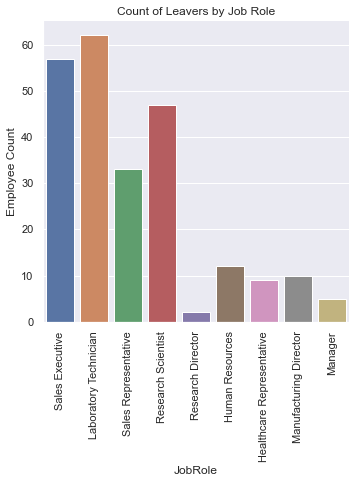

In [407]:
fig = sns.catplot(x='JobRole', kind='count', data=leaver_df )
fig.set(xlabel='JobRole', ylabel="Employee Count", title="Count of Leavers by Job Role")
fig.set_xticklabels(rotation=90);

In [408]:
leaver_df[leaver_df['Department'] == 'Research & Development'].describe(include='all')

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,133.000000,133,133,133.000000,133,133.000000,133.000000,133,133.000000,133.000000,133,133.000000,133.000000,133.000000,133,133.000000,133,133.000000,133.000000,133.000000,133,133,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000
unique,NaN,1,3,NaN,1,NaN,NaN,4,NaN,NaN,2,NaN,NaN,NaN,6,NaN,3,NaN,NaN,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Yes,Travel_Rarely,NaN,Research & Development,NaN,NaN,Life Sciences,NaN,NaN,Male,NaN,NaN,NaN,Laboratory Technician,NaN,Single,NaN,NaN,NaN,Y,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,133,88,NaN,133,NaN,NaN,59,NaN,NaN,90,NaN,NaN,NaN,62,NaN,66,NaN,NaN,NaN,133,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,33.473684,NaN,NaN,754.548872,NaN,10.263158,2.827068,NaN,949.744361,2.473684,NaN,66.834586,2.556391,1.421053,NaN,2.458647,NaN,4108.075188,14145.345865,2.924812,NaN,NaN,15.308271,3.195489,2.518797,0.518797,8.082707,2.586466,2.578947,4.954887,2.706767,1.872180,2.849624
std,9.902233,NaN,NaN,405.924561,NaN,8.386402,1.026256,NaN,557.743053,1.190740,NaN,20.579182,0.711523,0.872219,NaN,1.118110,NaN,3393.026241,7164.570549,2.675999,NaN,NaN,4.013576,0.398076,1.165160,0.812791,7.332002,1.256063,0.863489,6.048872,3.192752,3.262304,3.090788
min,18.000000,NaN,NaN,103.000000,NaN,1.000000,1.000000,NaN,4.000000,1.000000,NaN,31.000000,1.000000,1.000000,NaN,1.000000,NaN,1009.000000,2396.000000,0.000000,NaN,NaN,11.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,NaN,NaN,381.000000,NaN,3.000000,2.000000,NaN,440.000000,1.000000,NaN,50.000000,2.000000,1.000000,NaN,1.000000,NaN,2362.000000,8269.000000,1.000000,NaN,NaN,12.000000,3.000000,1.000000,0.000000,3.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,31.000000,NaN,NaN,699.000000,NaN,8.000000,3.000000,NaN,994.000000,3.000000,NaN,67.000000,3.000000,1.000000,NaN,3.000000,NaN,2759.000000,14180.000000,1.000000,NaN,NaN,14.000000,3.000000,3.000000,0.000000,7.000000,2.000000,3.000000,3.000000,2.000000,1.000000,2.000000
75%,38.000000,NaN,NaN,1097.000000,NaN,16.000000,4.000000,NaN,1389.000000,4.000000,NaN,85.000000,3.000000,1.000000,NaN,3.000000,NaN,4213.000000,20366.000000,5.000000,NaN,NaN,18.000000,3.000000,4.000000,1.000000,10.000000,3.000000,3.000000,7.000000,4.000000,2.000000,5.000000


# 3. Reusable Functions
Below cells contain functions that will be reused during the logistic regressions.

In [409]:
def get_features_and_target(dataframe, target_column):

    if isinstance(target_column, str):
        target = dataframe[target_column]
        features = dataframe.drop([target_column], axis=1)
    elif isinstance(target_column, pd.core.series.Series):
        target = target_column
        features = dataframe
        
    return features, target

In [410]:
def statsmodel_logit(features, target):

    if 'const' not in features.columns:
        features = sm.add_constant(features)
        
    # Create a Logit object
    sm_obj = sm.Logit(target, features)
    
    # Create a fitted logit model
    sm_model = sm_obj.fit()
    
    return sm_model

In [411]:
def sklearn_logit(features, target):

    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            sk_model = LogisticRegression(fit_intercept=True)
            sk_model.fit(features, target)
        except ConvergenceWarning:
            # The default max_iter is 1000. There are cases when during fitting, max_iter has been reached
            # If the fitting has encountered this warning, increase max_iter to 3000
            # Set C to a high number as well to make sure that statsmodels' coefs match with sklearn's
            sk_model = LogisticRegression(fit_intercept=True, C=1e9, max_iter=3000)
            sk_model.fit(features, target)

    score = sk_model.score(features, target)
    print('Model Accuracy Score: {}%'.format(score * 100))

    return sk_model

In [412]:
def sklearn_predict(sklearn_model, features, actual_target, title):
    predicted_target = sklearn_model.predict(features)
 
    labels = actual_target.unique()
    cm = plot_confusion_matrix(sklearn_model, X=features, y_true=actual_target, display_labels=labels,
                               values_format='.2f', cmap=plt.cm.Blues)
    cm.ax_.set_title(title)
    plt.show()

# 4. Logistic Regression on Initial Data State

This section attempts to train a model to predict which employee will be a part of the attrition. The dependent variable is <b>Attrition</b>. Since it has two values, Yes and No, I used binary logistic regression.  

<u>For clarity, the Attrition Values are:</u>  
Yes (1) = Employee left the company  
No (2) = Employee stayed in the company

## 4.1. Initial Data Preparation

### 4.1.1. Train Test Split
Before proceeding with the ```train_test_split```, I added a constant column of 1s. This will be useful later on for the Varianc Inflation Factor and for running statmodels' ```Logit```.

In [413]:
# Add constants column for the whole dataset
# https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python
hr_df = sm.add_constant(hr_df)

In [414]:
# Split the dataset into train and test
target = hr_df['Attrition']
features = hr_df.drop(['Attrition'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=432)

I turned ```x_train``` and ```y_train``` into ```train_df```. All preprocessing will be fitted on the ```train_df``` and applied to the ```test_df``` after. I also reinserted the ```Attrition``` at its original column index 0. This will come in handy later on during One Hot Encoding.

In [415]:
train_df = x_train.copy()
train_df.insert(0, 'Attrition', y_train)
train_df.reset_index(drop=True, inplace=True)
train_df.head(2)

,Attrition,const,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,No,1.0,31,Travel_Rarely,1274,Research & Development,9,1,Life Sciences,581,3,Male,33,3,3,Manufacturing Director,2,Divorced,10648,14394,1,Y,No,25,4,4,1,13,6,4,13,8,0,8
1,No,1.0,28,Travel_Rarely,640,Research & Development,1,3,Technical Degree,1301,4,Male,84,3,1,Research Scientist,1,Single,2080,4732,2,Y,No,11,3,2,0,5,2,2,3,2,1,2


Quick sanity check if the re-inserted ```Attrition``` column still has the same values with the original ```hr_df```. Join the train_df and hr_df on ```EmployeeNumber``` resulting to a new dataframe, ```check_train_df```.

In [416]:
check_train_df = pd.merge(left=train_df, right=hr_df, on=['EmployeeNumber'])

 If ```check_train_df.Attrition``` is not equal with ```hr_df.Attrition``` it should show some rows. Luckily, it didn't, so the reinserted Attrition column in ```train_df``` still retained the original values.

In [417]:
check_train_df[(check_train_df['Attrition_x'] != check_train_df['Attrition_y'])]

,Attrition_x,const_x,Age_x,BusinessTravel_x,DailyRate_x,Department_x,DistanceFromHome_x,Education_x,EducationField_x,EmployeeNumber,EnvironmentSatisfaction_x,Gender_x,HourlyRate_x,JobInvolvement_x,JobLevel_x,JobRole_x,JobSatisfaction_x,MaritalStatus_x,MonthlyIncome_x,MonthlyRate_x,NumCompaniesWorked_x,Over18_x,OverTime_x,PercentSalaryHike_x,PerformanceRating_x,RelationshipSatisfaction_x,StockOptionLevel_x,TotalWorkingYears_x,TrainingTimesLastYear_x,WorkLifeBalance_x,YearsAtCompany_x,YearsInCurrentRole_x,YearsSinceLastPromotion_x,YearsWithCurrManager_x,const_y,Age_y,Attrition_y,BusinessTravel_y,DailyRate_y,Department_y,DistanceFromHome_y,Education_y,EducationField_y,EnvironmentSatisfaction_y,Gender_y,HourlyRate_y,JobInvolvement_y,JobLevel_y,JobRole_y,JobSatisfaction_y,MaritalStatus_y,MonthlyIncome_y,MonthlyRate_y,NumCompaniesWorked_y,Over18_y,OverTime_y,PercentSalaryHike_y,PerformanceRating_y,RelationshipSatisfaction_y,StockOptionLevel_y,TotalWorkingYears_y,TrainingTimesLastYear_y,WorkLifeBalance_y,YearsAtCompany_y,YearsInCurrentRole_y,YearsSinceLastPromotion_y,YearsWithCurrManager_y


For the ```test_df```, do the same method as that for ```train_df```. A quick check ensured that the reinserted Attrition column still has the original values.

In [418]:
test_df = x_test.copy()
test_df.insert(0, 'Attrition', y_test)
test_df.reset_index(drop=True, inplace=True)
test_df.head(2)

,Attrition,const,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,Yes,1.0,50,Travel_Rarely,869,Sales,3,2,Marketing,47,1,Male,86,2,1,Sales Representative,3,Married,2683,3810,1,Y,Yes,14,3,3,0,3,2,3,3,2,0,2
1,No,1.0,27,Travel_Rarely,1103,Research & Development,14,3,Life Sciences,1244,1,Male,42,3,1,Research Scientist,1,Married,2235,14377,1,Y,Yes,14,3,4,2,9,3,2,9,7,6,8


In [419]:
check_test_df = pd.merge(left=test_df, right=hr_df, on=['EmployeeNumber'])
check_test_df[(check_test_df['Attrition_x'] != check_test_df['Attrition_y'])]

,Attrition_x,const_x,Age_x,BusinessTravel_x,DailyRate_x,Department_x,DistanceFromHome_x,Education_x,EducationField_x,EmployeeNumber,EnvironmentSatisfaction_x,Gender_x,HourlyRate_x,JobInvolvement_x,JobLevel_x,JobRole_x,JobSatisfaction_x,MaritalStatus_x,MonthlyIncome_x,MonthlyRate_x,NumCompaniesWorked_x,Over18_x,OverTime_x,PercentSalaryHike_x,PerformanceRating_x,RelationshipSatisfaction_x,StockOptionLevel_x,TotalWorkingYears_x,TrainingTimesLastYear_x,WorkLifeBalance_x,YearsAtCompany_x,YearsInCurrentRole_x,YearsSinceLastPromotion_x,YearsWithCurrManager_x,const_y,Age_y,Attrition_y,BusinessTravel_y,DailyRate_y,Department_y,DistanceFromHome_y,Education_y,EducationField_y,EnvironmentSatisfaction_y,Gender_y,HourlyRate_y,JobInvolvement_y,JobLevel_y,JobRole_y,JobSatisfaction_y,MaritalStatus_y,MonthlyIncome_y,MonthlyRate_y,NumCompaniesWorked_y,Over18_y,OverTime_y,PercentSalaryHike_y,PerformanceRating_y,RelationshipSatisfaction_y,StockOptionLevel_y,TotalWorkingYears_y,TrainingTimesLastYear_y,WorkLifeBalance_y,YearsAtCompany_y,YearsInCurrentRole_y,YearsSinceLastPromotion_y,YearsWithCurrManager_y


### 4.1.2. One-Hot Encoding the Training Dataset

These columns have categorical values. To be able to proceed with preprocessing and model fitting, I used One-Hot Encoding.

In [420]:
nominal_categories = ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 
                      'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']

Multicollinearity is the problem where 2 or more variables are highly correlated. To avoid this, the argument ```drop='first'``` is specified.

In [421]:
ohe = OneHotEncoder(categories='auto', drop='first')

Fit OHE on to the ```train_df```, then use it to transform the same dataframe.

In [422]:
ohe.fit(train_df[nominal_categories])
train_arr = ohe.transform(train_df[nominal_categories]).toarray()

These are the new feature names generated from OHE.

In [423]:
train_cols = ohe.get_feature_names()
train_cols_list = train_cols.tolist()
print(train_cols_list)

['x0_Yes', 'x1_Travel_Frequently', 'x1_Travel_Rarely', 'x2_Research & Development', 'x2_Sales', 'x3_Life Sciences', 'x3_Marketing', 'x3_Medical', 'x3_Other', 'x3_Technical Degree', 'x4_Male', 'x5_Human Resources', 'x5_Laboratory Technician', 'x5_Manager', 'x5_Manufacturing Director', 'x5_Research Director', 'x5_Research Scientist', 'x5_Sales Executive', 'x5_Sales Representative', 'x6_Married', 'x6_Single', 'x8_Yes']


For each new feature name, append the original column name with the new value name. Put them all in a list.

In [424]:
new_cols_list = []
for index, value in enumerate(train_cols_list):
    new_cols_list.append(nominal_categories[int(value[1])] + value[2:])
    continue
print(new_cols_list)

['Attrition_Yes', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Department_Research & Development', 'Department_Sales', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree', 'Gender_Male', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_Research Scientist', 'JobRole_Sales Executive', 'JobRole_Sales Representative', 'MaritalStatus_Married', 'MaritalStatus_Single', 'OverTime_Yes']


Create ```train_ohe_df``` with the transformed ```train_arr```. Label the columns with the ```new_cols_list```.

In [425]:
train_ohe_df = pd.DataFrame(train_arr, columns=new_cols_list)
train_ohe_df.head(2)

,Attrition_Yes,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Merge the original ```train_df``` and ```train_ohe_df``` by their indexes. The result will be the new value of ```train_df```.

In [426]:
train_df = pd.merge(left=train_df, right=train_ohe_df, left_index=True, right_index=True)

Drop the original nominal category columns so that only the one-hot encoded columns remain

In [427]:
train_df.drop(nominal_categories, axis=1, inplace=True)

Drop ```EmployeeNumber``` column since they will affect the model even if they are meaningless.

In [428]:
train_df.drop(['EmployeeNumber'], axis=1, inplace=True)

In [429]:
train_df.head(2)

,const,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_Yes,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,1.0,31,1274,9,1,3,33,3,3,2,10648,14394,1,25,4,4,1,13,6,4,13,8,0,8,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,28,640,1,3,4,84,3,1,1,2080,4732,2,11,3,2,0,5,2,2,3,2,1,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### 4.1.3.  Applying OHE to the Test Dataset
With the OHE fitted on the training dataset, use it again to transform the ```test_df```'s categorical columns. Do the same processing for ```test_df``` after.

In [430]:
test_arr = ohe.transform(test_df[nominal_categories]).toarray()

In [431]:
test_cols = ohe.get_feature_names()
test_cols_list = test_cols.tolist()

In [432]:
new_cols_list = []
for index, value in enumerate(test_cols_list):
    new_cols_list.append(nominal_categories[int(value[1])] + value[2:])
    continue

In [433]:
test_ohe_df = pd.DataFrame(test_arr, columns=new_cols_list)
test_ohe_df.head(2)

,Attrition_Yes,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [434]:
test_df = pd.merge(left=test_df, right=test_ohe_df, left_index=True, right_index=True)

In [435]:
test_df.drop(nominal_categories, axis=1, inplace=True)

In [436]:
test_df.drop(['EmployeeNumber'], axis=1, inplace=True)

### 4.1.4. Variance Inflation Factor
To detect multicollinearity, I used Variance Inflation Factor (VIF).

In [437]:
vif_df = pd.DataFrame()
variables = train_df.drop(['Attrition_Yes'], axis=1)
vif_df['Independent Variables'] = variables.columns
vif_df['VIF'] = [vif(variables.values, i) for i in range(variables.shape[1])]
vif_df.sort_values(by='VIF')

,Independent Variables,VIF
3,DistanceFromHome,1.019908
6,HourlyRate,1.030179
11,MonthlyRate,1.032481
33,Gender_Male,1.032588
9,JobSatisfaction,1.033529
15,RelationshipSatisfaction,1.035164
19,WorkLifeBalance,1.039642
7,JobInvolvement,1.041250
18,TrainingTimesLastYear,1.041352
5,EnvironmentSatisfaction,1.041774


Drop the columns whose VIF are greater than 10 from both ```train_df``` and ```test_df```.

In [438]:
high_vif_columns = vif_df[(vif_df['VIF'] > 10) & (vif_df['Independent Variables'] != 'const')]['Independent Variables']
high_vif_columns = high_vif_columns.values
print(high_vif_columns)

['JobLevel' 'MonthlyIncome' 'Department_Research & Development'
 'Department_Sales' 'EducationField_Life Sciences'
 'EducationField_Marketing' 'EducationField_Medical'
 'JobRole_Sales Executive']


In [439]:
train_df.drop(high_vif_columns, axis=1, inplace=True)
test_df.drop(high_vif_columns, axis=1, inplace=True)

## 4.2. Logistic Regression on Data after OHE and VIF

### 4.2.1. Training the Model

In [440]:
train_features, train_target = get_features_and_target(train_df, 'Attrition_Yes')

In [441]:
m1_sm_model = statsmodel_logit(train_features, train_target)

Optimization terminated successfully.
         Current function value: 0.284189
         Iterations 8


In [442]:
m1_sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1176
Model:                          Logit   Df Residuals:                     1139
Method:                           MLE   Df Model:                           36
Date:                Sun, 19 Apr 2020   Pseudo R-squ.:                  0.3448
Time:                        21:50:34   Log-Likelihood:                -334.21
converged:                       True   LL-Null:                       -510.10
Covariance Type:            nonrobust   LLR p-value:                 1.876e-53
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                1.6982      1.492      1.138      0.255      -1.226       4.623
Age                                 -0.0342      0.015     -2.232      0.026      -0.064      -0.004
DailyRate                           -0.0004      0.000     -1.441      0.150      -0.001       0.000
DistanceFromHome                     0.0522      0.012      4.287      0.000       0.028       0.076
Education                            0.0486      0.099      0.490      0.624      -0.146       0.243
EnvironmentSatisfaction             -0.4767      0.095     -5.026      0.000      -0.663      -0.291
HourlyRate                           0.0040      0.005      0.789      0.430      -0.006       0.014
JobInvolvement                      -0.5154      0.138     -3.730      0.000      -0.786      -0.245
JobSatisfaction                     -0.3393      0.094     -3.604      0.000      -0.524      -0.155
MonthlyRate                       1.398e-05   1.43e-05      0.978      0.328    -1.4e-05     4.2e-05
NumCompaniesWorked                   0.2226      0.042      5.247      0.000       0.139       0.306
PercentSalaryHike                   -0.0340      0.045     -0.753      0.451      -0.122       0.054
PerformanceRating                    0.2377      0.454      0.524      0.600      -0.651       1.127
RelationshipSatisfaction            -0.2209      0.094     -2.348      0.019      -0.405      -0.037
StockOptionLevel                    -0.2917      0.176     -1.659      0.097      -0.636       0.053
TotalWorkingYears                   -0.0684      0.030     -2.286      0.022      -0.127      -0.010
TrainingTimesLastYear               -0.2558      0.083     -3.080      0.002      -0.419      -0.093
WorkLifeBalance                     -0.4144      0.143     -2.888      0.004      -0.696      -0.133
YearsAtCompany                       0.1050      0.043      2.462      0.014       0.021       0.189
YearsInCurrentRole                  -0.1519      0.051     -2.958      0.003      -0.253      -0.051
YearsSinceLastPromotion              0.1603      0.048      3.363      0.001       0.067       0.254
YearsWithCurrManager                -0.1455      0.051     -2.826      0.005      -0.246      -0.045
BusinessTravel_Travel_Frequently     1.7595      0.475      3.706      0.000       0.829       2.690
BusinessTravel_Travel_Rarely         1.0772      0.437      2.465      0.014       0.221       1.934
EducationField_Other                 0.1825      0.451      0.405      0.686      -0.701       1.066
EducationField_Technical Degree      0.9444      0.318      2.971      0.003       0.321       1.567
Gender_Male                          0.4026      0.210      1.919      0.055      -0.009       0.814
JobRole_Human Resources              0.8306      0.486      1.707      0.088      -0.123       1.784
JobRole_Laboratory Technician        0.5852      0.291      2.010      0.044       0.014       1.156
JobRole_M

In [443]:
sk_model = sklearn_logit(train_features, train_target)

Model Accuracy Score: 89.28571428571429%


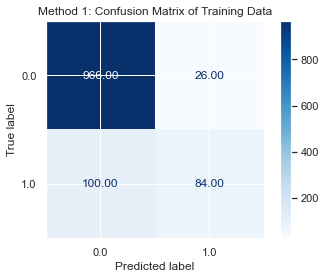

In [444]:
sklearn_predict(sk_model, train_features, train_target, title='Method 1: Confusion Matrix of Training Data')

### 4.2.2 Testing the Model

In [445]:
test_features, test_target = get_features_and_target(test_df, 'Attrition_Yes')

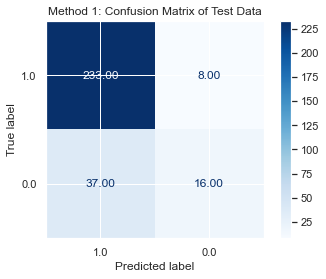

In [446]:
sklearn_predict(sk_model, test_features, test_target, title='Method 1: Confusion Matrix of Test Data')

### 4.2.3. Conclusion

The model has an accuracy score of <b>89.29%</b>. The pseudo R-squared is <b>0.3448</b>. However, from statsmodels' summary, there are many variables whose p-values are greater than 0.05 .  

There is a possibility that accuracy can be increased if scaled data is used. In the next section, the data will be scaled.

# 5. Logistic Regression on a Scaled Dataset

## 5.1. Fitting the Scaler on the Training Dataset
The ```scaled_train_df``` is a copy of ```train_df```. Sklearn's ```StandardScaler``` is fitted on the training data. The scaled results are now in the ```scaled_train_df```.

During fitting and transforming, columns ```Attrition_Yes``` and ```const``` shouldn't be scaled so I left them out.

In [447]:
scaled_train_df = train_df.copy()

In [448]:
scaler = StandardScaler()
scaler.fit(scaled_train_df.drop(['Attrition_Yes', 'const'], axis=1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [449]:
scaled_train_arr = scaler.transform(train_df.drop(['Attrition_Yes', 'const'], axis=1))

Put the results ```scaled_train_arr``` in a dataframe, then merge them back with ```train_df```'s columns ```Attrition_Yes``` and ```const```.

In [450]:
scaled_train_df = pd.DataFrame(scaled_train_arr, columns=train_df.drop(['Attrition_Yes', 'const'], axis=1).columns)
scaled_train_df = pd.merge(left=scaled_train_df, right=train_df[['Attrition_Yes', 'const']], left_index=True, right_index=True)
scaled_train_df.head(3)

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,Attrition_Yes,const
0,-0.689868,1.143634,-0.016933,-1.917270,0.236912,-1.614977,0.392794,-0.649704,0.020201,-0.695759,2.687165,2.367856,1.190677,0.211383,0.199999,2.490413,1.758492,0.960155,1.019052,-0.677871,1.071443,-0.483733,0.640369,-0.235914,-0.311472,0.820263,-0.194814,-0.455403,-0.287877,3.008535,-0.243843,-0.482394,-0.239904,-0.904223,-0.674867,-0.632456,0.0,1.0
1,-1.021999,-0.409053,-1.006426,0.071887,1.156410,0.906036,0.392794,-1.562550,-1.338901,-0.295264,-1.159252,-0.422323,-0.659041,-0.944831,-0.823161,-0.617813,-1.093903,-0.655906,-0.615880,-0.372790,-0.601146,-0.483733,0.640369,-0.235914,3.210560,0.820263,-0.194814,-0.455403,-0.287877,-0.332388,-0.243843,2.072992,-0.239904,-0.904223,1.481773,-0.632456,0.0,1.0
2,1.967178,0.695461,-0.882739,-1.917270,1.156410,-0.033165,0.392794,-0.649704,0.219804,0.105232,0.763957,-0.422323,-0.659041,0.211383,1.478949,0.936300,0.332294,-0.655906,-0.615880,-0.372790,-0.601146,2.067255,-1.561601,-0.235914,-0.311472,0.820263,-0.194814,-0.455403,-0.287877,3.008535,-0.243843,-0.482394,-0.239904,1.105922,-0.674867,-0.632456,0.0,1.0


## 5.2 Scaling the Test Dataset
Apply the fitted StandardScaler to transform the test dataset. After that, do the same steps to get ```scaled_test_df```.

In [451]:
scaled_test_arr = scaler.transform(test_df.drop(['Attrition_Yes', 'const'], axis=1))

In [452]:
scaled_test_df = pd.DataFrame(scaled_test_arr, columns=test_df.drop(['Attrition_Yes', 'const'], axis=1).columns)
scaled_test_df = pd.merge(left=scaled_test_df, right=test_df[['Attrition_Yes', 'const']], left_index=True, right_index=True)
scaled_test_df.head(3)

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,Attrition_Yes,const
0,1.413627,0.151775,-0.759053,-0.922691,-1.602085,1.004900,-1.002752,0.263142,-1.468594,-0.695759,-0.335020,-0.422323,0.265818,-0.944831,-1.078951,-0.617813,0.332294,-0.655906,-0.615880,-0.677871,-0.601146,-0.483733,0.640369,-0.235914,-0.311472,0.820263,-0.194814,-0.455403,-0.287877,-0.332388,-0.243843,-0.482394,4.168333,1.105922,-0.674867,1.581139,1.0,1.0
1,-1.132709,0.724849,0.601500,0.071887,-1.602085,-1.170092,0.392794,-1.562550,0.017809,-0.695759,-0.335020,-0.422323,1.190677,1.367596,-0.311581,0.159244,-1.093903,0.313730,0.746563,1.152614,1.071443,-0.483733,0.640369,-0.235914,-0.311472,0.820263,-0.194814,-0.455403,-0.287877,-0.332388,-0.243843,2.072992,-0.239904,1.105922,-0.674867,1.581139,0.0,1.0
2,-0.136317,-0.607425,0.354126,1.066465,0.236912,0.510583,0.392794,0.263142,-0.257331,2.508208,-0.884508,-0.422323,-0.659041,1.367596,-0.567371,-0.617813,0.332294,-0.655906,-0.615880,-0.372790,-0.879911,-0.483733,0.640369,-0.235914,-0.311472,-1.219122,-0.194814,-0.455403,-0.287877,3.008535,-0.243843,-0.482394,-0.239904,1.105922,-0.674867,1.581139,0.0,1.0


## 5.3. Logistic Regression on Scaled Data

### 5.3.1. Training the Model

In [453]:
train_features, train_target = get_features_and_target(scaled_train_df, 'Attrition_Yes')

In [454]:
m2_sm_model = statsmodel_logit(train_features, train_target)

Optimization terminated successfully.
         Current function value: 0.284189
         Iterations 8


In [455]:
m2_sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1176
Model:                          Logit   Df Residuals:                     1139
Method:                           MLE   Df Model:                           36
Date:                Sun, 19 Apr 2020   Pseudo R-squ.:                  0.3448
Time:                        21:50:36   Log-Likelihood:                -334.21
converged:                       True   LL-Null:                       -510.10
Covariance Type:            nonrobust   LLR p-value:                 1.876e-53
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Age                                 -0.3088      0.138     -2.232      0.026      -0.580      -0.038
DailyRate                           -0.1458      0.101     -1.441      0.150      -0.344       0.053
DistanceFromHome                     0.4218      0.098      4.287      0.000       0.229       0.615
Education                            0.0488      0.100      0.490      0.624      -0.146       0.244
EnvironmentSatisfaction             -0.5185      0.103     -5.026      0.000      -0.721      -0.316
HourlyRate                           0.0810      0.103      0.789      0.430      -0.120       0.282
JobInvolvement                      -0.3693      0.099     -3.730      0.000      -0.563      -0.175
JobSatisfaction                     -0.3717      0.103     -3.604      0.000      -0.574      -0.170
MonthlyRate                          0.0994      0.102      0.978      0.328      -0.100       0.299
NumCompaniesWorked                   0.5558      0.106      5.247      0.000       0.348       0.763
PercentSalaryHike                   -0.1238      0.164     -0.753      0.451      -0.446       0.198
PerformanceRating                    0.0852      0.163      0.524      0.600      -0.233       0.404
RelationshipSatisfaction            -0.2389      0.102     -2.348      0.019      -0.438      -0.039
StockOptionLevel                    -0.2523      0.152     -1.659      0.097      -0.550       0.046
TotalWorkingYears                   -0.5345      0.234     -2.286      0.022      -0.993      -0.076
TrainingTimesLastYear               -0.3292      0.107     -3.080      0.002      -0.539      -0.120
WorkLifeBalance                     -0.2906      0.101     -2.888      0.004      -0.488      -0.093
YearsAtCompany                       0.6495      0.264      2.462      0.014       0.133       1.166
YearsInCurrentRole                  -0.5574      0.188     -2.958      0.003      -0.927      -0.188
YearsSinceLastPromotion              0.5255      0.156      3.363      0.001       0.219       0.832
YearsWithCurrManager                -0.5220      0.185     -2.826      0.005      -0.884      -0.160
BusinessTravel_Travel_Frequently     0.6897      0.186      3.706      0.000       0.325       1.055
BusinessTravel_Travel_Rarely         0.4892      0.198      2.465      0.014       0.100       0.878
EducationField_Other                 0.0408      0.101      0.405      0.686      -0.157       0.238
EducationField_Technical Degree      0.2681      0.090      2.971      0.003       0.091       0.445
Gender_Male                          0.1974      0.103      1.919      0.055      -0.004       0.399
JobRole_Human Resources              0.1559      0.091      1.707      0.088      -0.023       0.335
JobRole_Laboratory Technician        0.2207      0.110      2.010      0.044       0.005       0.436
JobRole_Manager                     -0.2015      0.169     -1.194      0.232      -0.532       0.129
JobRole_M

In [456]:
m2_sk_model = sklearn_logit(train_features, train_target)

Model Accuracy Score: 89.62585034013605%


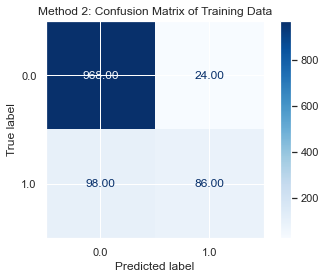

In [457]:
sklearn_predict(m2_sk_model, train_features, train_target, title='Method 2: Confusion Matrix of Training Data')

### 5.3.2. Testing the Model

In [458]:
test_features, test_target = get_features_and_target(scaled_test_df, 'Attrition_Yes')

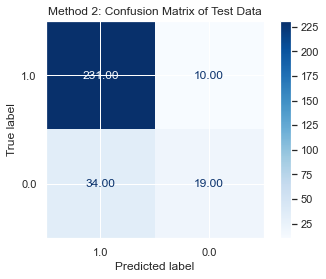

In [459]:
sklearn_predict(m2_sk_model, test_features, test_target, title='Method 2: Confusion Matrix of Test Data')

### 5.3.2. Conclusion

The model has an accuracy score of <b>89.62%</b>. It's an increase of 0.33% from the previous model. However, the pseudo R-squared is still <b>0.3448</b> and there are still a lot of variables whose p-values are greater than 0.05 .

# 6. Logistic Regression of Selected Features

## 6.1. Recursive Feature Elimination with Cross Validation (RFECV)

In [249]:
log_reg = LogisticRegression()

In [250]:
rfecv = RFECV(estimator=log_reg, cv=StratifiedKFold(), scoring='accuracy')

In [251]:
rfecv.fit(scaled_train_df.drop(['Attrition_Yes', 'const'], axis=1), scaled_train_df['Attrition_Yes'])

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='auto', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='lbfgs', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

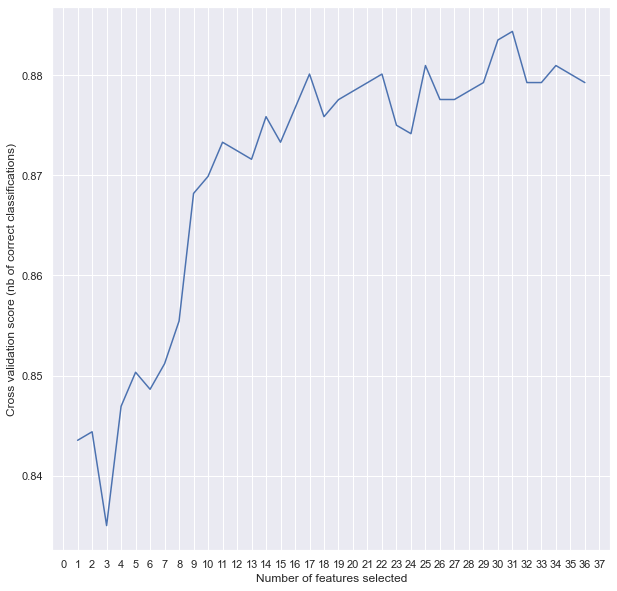

In [252]:
plt.figure(figsize=(10, 10))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.xticks(np.arange(0,50,1));
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_);

Based on this plot, the most ideal number of features is 31.

In [253]:
rfecv.get_support(indices=True)

array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35],
      dtype=int32)

In [254]:
rfecv_idx = rfecv.get_support(indices=True).tolist()

In [255]:
scaled_train_df.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,Attrition_Yes,const
0,-0.689868,1.143634,-0.016933,-1.917270,0.236912,-1.614977,0.392794,-0.649704,0.020201,-0.695759,2.687165,2.367856,1.190677,0.211383,0.199999,2.490413,1.758492,0.960155,1.019052,-0.677871,1.071443,-0.483733,0.640369,-0.235914,-0.311472,0.820263,-0.194814,-0.455403,-0.287877,3.008535,-0.243843,-0.482394,-0.239904,-0.904223,-0.674867,-0.632456,0.0,1.0
1,-1.021999,-0.409053,-1.006426,0.071887,1.156410,0.906036,0.392794,-1.562550,-1.338901,-0.295264,-1.159252,-0.422323,-0.659041,-0.944831,-0.823161,-0.617813,-1.093903,-0.655906,-0.615880,-0.372790,-0.601146,-0.483733,0.640369,-0.235914,3.210560,0.820263,-0.194814,-0.455403,-0.287877,-0.332388,-0.243843,2.072992,-0.239904,-0.904223,1.481773,-0.632456,0.0,1.0
2,1.967178,0.695461,-0.882739,-1.917270,1.156410,-0.033165,0.392794,-0.649704,0.219804,0.105232,0.763957,-0.422323,-0.659041,0.211383,1.478949,0.936300,0.332294,-0.655906,-0.615880,-0.372790,-0.601146,2.067255,-1.561601,-0.235914,-0.311472,0.820263,-0.194814,-0.455403,-0.287877,3.008535,-0.243843,-0.482394,-0.239904,1.105922,-0.674867,-0.632456,0.0,1.0
3,-0.136317,-0.923350,-0.882739,1.066465,1.156410,0.362288,0.392794,-0.649704,0.748703,0.505728,1.862933,2.367856,1.190677,0.211383,0.455789,-0.617813,0.332294,-0.979119,-1.160857,-0.677871,-1.158676,-0.483733,0.640369,4.238837,-0.311472,-1.219122,-0.194814,-0.455403,-0.287877,-0.332388,-0.243843,2.072992,-0.239904,1.105922,-0.674867,1.581139,0.0,1.0
4,1.745757,-1.726632,1.714679,1.066465,1.156410,0.312857,0.392794,1.175987,0.837743,1.306720,0.763957,-0.422323,0.265818,-0.944831,2.757900,-2.171925,0.332294,0.798548,1.291540,0.237371,1.071443,-0.483733,0.640369,-0.235914,-0.311472,-1.219122,-0.194814,-0.455403,-0.287877,-0.332388,4.100998,-0.482394,-0.239904,-0.904223,1.481773,-0.632456,0.0,1.0


In [256]:
cols_to_retain = scaled_train_df.iloc[:, rfecv_idx].columns.tolist()
cols_to_retain.append('Attrition_Yes')
cols_to_retain.append('const')
print(len(cols_to_retain))

33


In [257]:
scaled_train_df = scaled_train_df[cols_to_retain]

In [258]:
scaled_test_df = scaled_test_df[cols_to_retain]

## Train Model on Scaled, RFECV Training Dataset

In [259]:
train_features, train_target = get_features_and_target(scaled_train_df, 'Attrition_Yes')

In [260]:
m3_sm_model = statsmodel_logit(train_features, train_target)

Optimization terminated successfully.
         Current function value: 0.284805
         Iterations 8


In [261]:
m3_sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1176
Model:                          Logit   Df Residuals:                     1144
Method:                           MLE   Df Model:                           31
Date:                Sun, 19 Apr 2020   Pseudo R-squ.:                  0.3434
Time:                        18:00:03   Log-Likelihood:                -334.93
converged:                       True   LL-Null:                       -510.10
Covariance Type:            nonrobust   LLR p-value:                 9.291e-56
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Age                                 -0.2975      0.137     -2.174      0.030      -0.566      -0.029
DailyRate                           -0.1410      0.101     -1.400      0.162      -0.338       0.056
DistanceFromHome                     0.4199      0.098      4.283      0.000       0.228       0.612
EnvironmentSatisfaction             -0.5156      0.102     -5.048      0.000      -0.716      -0.315
JobInvolvement                      -0.3673      0.098     -3.729      0.000      -0.560      -0.174
JobSatisfaction                     -0.3806      0.102     -3.713      0.000      -0.581      -0.180
MonthlyRate                          0.0909      0.101      0.904      0.366      -0.106       0.288
NumCompaniesWorked                   0.5521      0.106      5.227      0.000       0.345       0.759
PercentSalaryHike                   -0.0569      0.103     -0.553      0.580      -0.258       0.144
RelationshipSatisfaction            -0.2383      0.101     -2.356      0.018      -0.436      -0.040
StockOptionLevel                    -0.2596      0.152     -1.710      0.087      -0.557       0.038
TotalWorkingYears                   -0.5119      0.228     -2.242      0.025      -0.959      -0.064
TrainingTimesLastYear               -0.3240      0.107     -3.042      0.002      -0.533      -0.115
WorkLifeBalance                     -0.2858      0.100     -2.864      0.004      -0.481      -0.090
YearsAtCompany                       0.6353      0.262      2.424      0.015       0.122       1.149
YearsInCurrentRole                  -0.5461      0.187     -2.916      0.004      -0.913      -0.179
YearsSinceLastPromotion              0.5185      0.155      3.342      0.001       0.214       0.823
YearsWithCurrManager                -0.5086      0.183     -2.776      0.006      -0.868      -0.149
BusinessTravel_Travel_Frequently     0.6959      0.185      3.767      0.000       0.334       1.058
BusinessTravel_Travel_Rarely         0.4929      0.197      2.503      0.012       0.107       0.879
EducationField_Technical Degree      0.2644      0.090      2.941      0.003       0.088       0.441
Gender_Male                          0.1929      0.103      1.881      0.060      -0.008       0.394
JobRole_Human Resources              0.1635      0.087      1.869      0.062      -0.008       0.335
JobRole_Laboratory Technician        0.2414      0.096      2.519      0.012       0.054       0.429
JobRole_Manager                     -0.1864      0.167     -1.117      0.264      -0.513       0.141
JobRole_Manufacturing Director      -0.2926      0.147     -1.993      0.046      -0.580      -0.005
JobRole_Research Director           -0.3126      0.191     -1.639      0.101      -0.686       0.061
JobRole_Sales Representative         0.2761      0.085      3.260      0.001       0.110       0.442
MaritalStatus_Married                0.2026      0.151      1.339      0.181      -0.094       0.499
MaritalSt

In [262]:
m3_sk_model = sklearn_logit(train_features, train_target)

Model Accuracy Score: 89.54081632653062%


In [263]:
m3_sk_model.coef_

array([[-2.97378554e-01, -1.40771794e-01,  4.07441254e-01,
        -5.01844952e-01, -3.60650691e-01, -3.69169649e-01,
         8.93236770e-02,  5.32076957e-01, -5.84390868e-02,
        -2.29830997e-01, -2.59908628e-01, -4.69172865e-01,
        -3.15446877e-01, -2.78011298e-01,  5.60090560e-01,
        -5.11904140e-01,  5.05660299e-01, -4.78719908e-01,
         6.49616530e-01,  4.45699426e-01,  2.56383266e-01,
         1.86954006e-01,  1.61174231e-01,  2.38967651e-01,
        -1.79611930e-01, -2.87724428e-01, -3.01696878e-01,
         2.72943462e-01,  1.85543401e-01,  4.68835661e-01,
         8.71363976e-01, -5.48095202e-04]])

[[968  24]
 [ 99  85]]


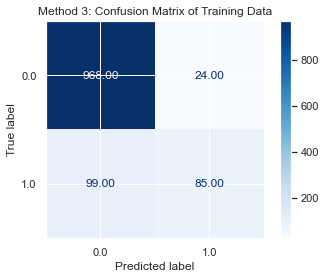

In [264]:
sklearn_predict(m3_sk_model, train_features, train_target, title='Method 3: Confusion Matrix of Training Data')

In [265]:
test_features, test_target = get_features_and_target(scaled_test_df, 'Attrition_Yes')

[[230  11]
 [ 34  19]]


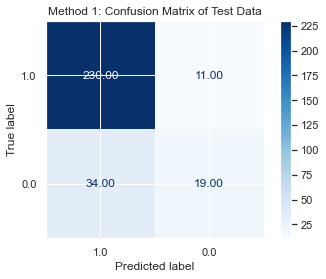

In [266]:
sklearn_predict(m3_sk_model, test_features, test_target, title='Method 1: Confusion Matrix of Test Data')

# Method 4: Drop p-values > 0.05

In [267]:
insignificant_cols = ['DailyRate', 'MonthlyRate', 'PercentSalaryHike', 'StockOptionLevel',
                      'Gender_Male', 'JobRole_Human Resources', 'JobRole_Manager',
                      'JobRole_Research Director', 'MaritalStatus_Married']

In [268]:
scaled_train_df.drop(insignificant_cols, axis=1, inplace=True)

In [269]:
scaled_test_df.drop(insignificant_cols, axis=1, inplace=True)

## Train

In [270]:
train_features, train_target = get_features_and_target(scaled_train_df, 'Attrition_Yes')

In [271]:
m4_sm_model = statsmodel_logit(train_features, train_target)

Optimization terminated successfully.
         Current function value: 0.293821
         Iterations 8


In [274]:
m4_sm_model.prsquared

0.32261357128047796

In [122]:
m4_sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1176
Model:                          Logit   Df Residuals:                     1153
Method:                           MLE   Df Model:                           22
Date:                Sun, 19 Apr 2020   Pseudo R-squ.:                  0.3226
Time:                        17:48:20   Log-Likelihood:                -345.53
converged:                       True   LL-Null:                       -510.10
Covariance Type:            nonrobust   LLR p-value:                 1.449e-56
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Age                                 -0.2960      0.136     -2.173      0.030      -0.563      -0.029
DistanceFromHome                     0.4012      0.095      4.233      0.000       0.215       0.587
EnvironmentSatisfaction             -0.5164      0.101     -5.132      0.000      -0.714      -0.319
JobInvolvement                      -0.3778      0.096     -3.929      0.000      -0.566      -0.189
JobSatisfaction                     -0.3786      0.100     -3.792      0.000      -0.574      -0.183
NumCompaniesWorked                   0.5261      0.103      5.128      0.000       0.325       0.727
RelationshipSatisfaction            -0.2126      0.098     -2.163      0.031      -0.405      -0.020
TotalWorkingYears                   -0.6428      0.210     -3.065      0.002      -1.054      -0.232
TrainingTimesLastYear               -0.3526      0.105     -3.355      0.001      -0.559      -0.147
WorkLifeBalance                     -0.2740      0.097     -2.821      0.005      -0.464      -0.084
YearsAtCompany                       0.6010      0.256      2.346      0.019       0.099       1.103
YearsInCurrentRole                  -0.4914      0.184     -2.676      0.007      -0.851      -0.132
YearsSinceLastPromotion              0.5037      0.149      3.383      0.001       0.212       0.795
YearsWithCurrManager                -0.5145      0.183     -2.807      0.005      -0.874      -0.155
BusinessTravel_Travel_Frequently     0.7196      0.180      4.005      0.000       0.367       1.072
BusinessTravel_Travel_Rarely         0.5055      0.192      2.627      0.009       0.128       0.883
EducationField_Technical Degree      0.2639      0.089      2.978      0.003       0.090       0.438
JobRole_Laboratory Technician        0.2204      0.093      2.373      0.018       0.038       0.402
JobRole_Manufacturing Director      -0.2760      0.141     -1.952      0.051      -0.553       0.001
JobRole_Sales Representative         0.2448      0.083      2.962      0.003       0.083       0.407
MaritalStatus_Single                 0.5097      0.096      5.313      0.000       0.322       0.698
OverTime_Yes                         0.8408      0.095      8.808      0.000       0.654       1.028
const                               -2.6231      0.147    -17.813      0.000      -2.912      -2.334
====================================================================================================
"""

In [123]:
m4_sk_model = sklearn_logit(train_features, train_target)

Model Accuracy Score: 89.54081632653062%


In [124]:
m4_sk_model.coef_

array([[-2.97704593e-01,  3.90464748e-01, -5.02992826e-01,
        -3.71411881e-01, -3.68418250e-01,  5.08408845e-01,
        -2.05260062e-01, -5.96576355e-01, -3.43765332e-01,
        -2.67680381e-01,  5.32314966e-01, -4.64253719e-01,
         4.92993624e-01, -4.85723760e-01,  6.75089240e-01,
         4.60197045e-01,  2.56961386e-01,  2.18924935e-01,
        -2.72233904e-01,  2.42531371e-01,  4.98343801e-01,
         8.24653693e-01,  3.14513576e-04]])

[[969  23]
 [100  84]]


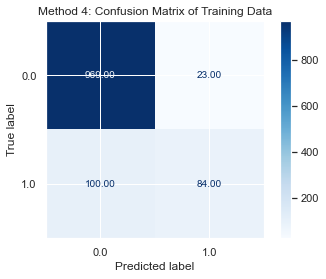

In [125]:
sklearn_predict(m4_sk_model, train_features, train_target, title='Method 4: Confusion Matrix of Training Data')

In [126]:
test_features, test_target = get_features_and_target(scaled_test_df, 'Attrition_Yes')

[[235   6]
 [ 34  19]]


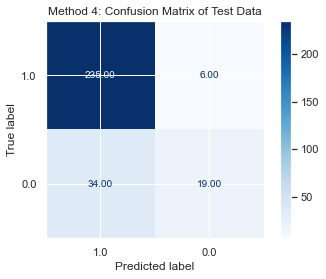

In [127]:
sklearn_predict(m4_sk_model, test_features, test_target, title='Method 4: Confusion Matrix of Test Data')

# Method 5: Oversampling with SMOTE

In [128]:
smote = SMOTE(random_state=18)

In [129]:
train_target = scaled_train_df['Attrition_Yes']
train_scaled_features = scaled_train_df.drop(['Attrition_Yes'], axis=1)

In [130]:
smote_train_feat, smote_train_target = smote.fit_sample(train_scaled_features, train_target)

In [131]:
smote_train_feat

,Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobSatisfaction,NumCompaniesWorked,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,EducationField_Technical Degree,JobRole_Laboratory Technician,JobRole_Manufacturing Director,JobRole_Sales Representative,MaritalStatus_Single,OverTime_Yes,const
0,-0.689868,-0.016933,0.236912,0.392794,-0.649704,-0.695759,1.190677,0.199999,2.490413,1.758492,0.960155,1.019052,-0.677871,1.071443,-0.483733,0.640369,-0.311472,-0.455403,3.008535,-0.239904,-0.674867,-0.632456,1.0
1,-1.021999,-1.006426,1.156410,0.392794,-1.562550,-0.295264,-0.659041,-0.823161,-0.617813,-1.093903,-0.655906,-0.615880,-0.372790,-0.601146,-0.483733,0.640369,3.210560,-0.455403,-0.332388,-0.239904,1.481773,-0.632456,1.0
2,1.967178,-0.882739,1.156410,0.392794,-0.649704,0.105232,-0.659041,1.478949,0.936300,0.332294,-0.655906,-0.615880,-0.372790,-0.601146,2.067255,-1.561601,-0.311472,-0.455403,3.008535,-0.239904,-0.674867,-0.632456,1.0
3,-0.136317,-0.882739,1.156410,0.392794,-0.649704,0.505728,1.190677,0.455789,-0.617813,0.332294,-0.979119,-1.160857,-0.677871,-1.158676,-0.483733,0.640369,-0.311472,-0.455403,-0.332388,-0.239904,-0.674867,1.581139,1.0
4,1.745757,1.714679,1.156410,0.392794,1.175987,1.306720,0.265818,2.757900,-2.171925,0.332294,0.798548,1.291540,0.237371,1.071443,-0.483733,0.640369,-0.311472,-0.455403,-0.332388,-0.239904,1.481773,-0.632456,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979,0.513015,1.217550,0.254625,1.761456,0.263142,1.260428,1.172860,-0.572299,-0.647752,0.304820,-0.811286,-0.615880,-0.061832,-0.601146,2.067255,-1.561601,-0.311472,-0.455403,-0.332388,-0.239904,-0.674867,1.581139,1.0
1980,-0.481899,1.056945,-1.160956,-0.276719,-0.612733,0.697866,-0.659041,-0.015153,-0.245020,0.332294,-0.565286,-0.615880,-0.385146,-0.746174,-0.483733,0.640369,-0.311472,-0.455403,-0.332388,-0.239904,-0.674867,1.581139,1.0
1981,-1.979311,1.023412,1.156410,0.392794,0.585366,-0.695759,0.537747,-1.372345,-0.343520,-0.590471,-1.026634,-0.968486,-0.677871,-0.961874,0.416738,-0.136903,-0.311472,-0.455403,-0.332388,4.168333,1.481773,1.581139,1.0
1982,-0.062025,1.141806,-0.682587,-0.534516,-1.562550,1.174975,-0.659041,0.626596,-0.101476,0.332294,-0.871735,-0.798732,-0.272432,-0.788210,-0.483733,0.640369,-0.311472,-0.455403,-0.332388,-0.239904,-0.674867,1.581139,1.0


In [132]:
smote_train_target.value_counts()

1.0    992
0.0    992
Name: Attrition_Yes, dtype: int64

## Train Model on Scaled and Balanced Training Dataset

In [140]:
train_features, train_target = get_features_and_target(smote_train_feat, smote_train_target)

In [141]:
m5_sm_model = statsmodel_logit(train_features, train_target)

Optimization terminated successfully.
         Current function value: 0.447414
         Iterations 7


In [142]:
m5_sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1984
Model:                          Logit   Df Residuals:                     1961
Method:                           MLE   Df Model:                           22
Date:                Sun, 19 Apr 2020   Pseudo R-squ.:                  0.3545
Time:                        17:53:26   Log-Likelihood:                -887.67
converged:                       True   LL-Null:                       -1375.2
Covariance Type:            nonrobust   LLR p-value:                3.941e-192
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Age                                 -0.1643      0.085     -1.924      0.054      -0.332       0.003
DistanceFromHome                     0.4250      0.062      6.815      0.000       0.303       0.547
EnvironmentSatisfaction             -0.5234      0.063     -8.364      0.000      -0.646      -0.401
JobInvolvement                      -0.3436      0.063     -5.435      0.000      -0.468      -0.220
JobSatisfaction                     -0.3701      0.064     -5.825      0.000      -0.495      -0.246
NumCompaniesWorked                   0.5161      0.069      7.518      0.000       0.382       0.651
RelationshipSatisfaction            -0.1254      0.062     -2.035      0.042      -0.246      -0.005
TotalWorkingYears                   -0.7765      0.133     -5.821      0.000      -1.038      -0.515
TrainingTimesLastYear               -0.4546      0.067     -6.760      0.000      -0.586      -0.323
WorkLifeBalance                     -0.1919      0.062     -3.112      0.002      -0.313      -0.071
YearsAtCompany                       0.6416      0.152      4.223      0.000       0.344       0.939
YearsInCurrentRole                  -0.4597      0.117     -3.915      0.000      -0.690      -0.230
YearsSinceLastPromotion              0.4671      0.090      5.216      0.000       0.292       0.643
YearsWithCurrManager                -0.4277      0.109     -3.939      0.000      -0.640      -0.215
BusinessTravel_Travel_Frequently     0.8406      0.120      6.999      0.000       0.605       1.076
BusinessTravel_Travel_Rarely         0.7964      0.129      6.171      0.000       0.543       1.049
EducationField_Technical Degree      0.1889      0.060      3.173      0.002       0.072       0.306
JobRole_Laboratory Technician        0.1346      0.061      2.207      0.027       0.015       0.254
JobRole_Manufacturing Director      -0.3799      0.088     -4.315      0.000      -0.552      -0.207
JobRole_Sales Representative         0.2244      0.054      4.121      0.000       0.118       0.331
MaritalStatus_Single                 0.4867      0.061      7.969      0.000       0.367       0.606
OverTime_Yes                         0.8315      0.060     13.922      0.000       0.714       0.949
const                               -0.9714      0.076    -12.795      0.000      -1.120      -0.823
====================================================================================================
"""

In [143]:
m5_sk_model = sklearn_logit(train_features, train_target)

Model Accuracy Score: 79.83870967741935%


In [144]:
m5_sk_model.coef_

array([[-1.69029249e-01,  4.19789476e-01, -5.18142652e-01,
        -3.40718727e-01, -3.65692376e-01,  5.08429882e-01,
        -1.23579007e-01, -7.52460975e-01, -4.49722999e-01,
        -1.89925124e-01,  6.13090807e-01, -4.47600395e-01,
         4.62315410e-01, -4.19554749e-01,  8.14572784e-01,
         7.67977828e-01,  1.86671368e-01,  1.35264444e-01,
        -3.77472431e-01,  2.24172634e-01,  4.82747380e-01,
         8.25177937e-01,  3.85167407e-05]])

[[781 211]
 [189 803]]


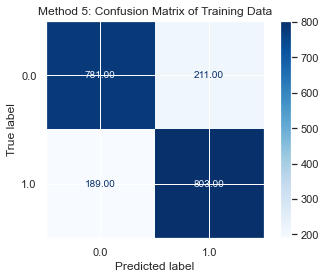

In [145]:
sklearn_predict(m5_sk_model, train_features, train_target, title='Method 5: Confusion Matrix of Training Data')

In [148]:
test_features, test_target = get_features_and_target(scaled_test_df, 'Attrition_Yes')

[[180  61]
 [ 15  38]]


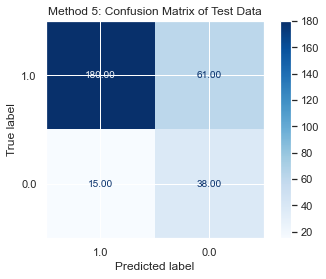

In [149]:
sklearn_predict(m5_sk_model, test_features, test_target, title='Method 5: Confusion Matrix of Test Data')